In [1]:
import math
import napari
import numpy as np
import tifffile as tf

from PyQt5.QtWidgets import QFileDialog
from matplotlib import pyplot as plt

Create a Napari Viewer instance and prompt user to select image file.

In [2]:
# QFileDialog seems to require a running PyQt app
viewer = napari.Viewer()

# prompt user to select tiff file for analysis
fname = QFileDialog.getOpenFileName(None, 'Open file', 'C:\\Users\\lukas',"Image files (*.tif)")[0]

Confirm that the raw imaging data is either unsigned 8- or 16-bit. Convert data to floating point.

In [3]:
img = tf.imread(fname)

# confirm valid image data type
if img.dtype not in (np.uint8, np.uint16):
    print(f"Image has unsuported data type {img.dtype}")
    raise TypeError

# convert to floating point
img = img.astype(np.float64)

# subtract top and bottom planes for later comparison
subtraction = img[0] - img[1]

Shift the top and bottom images relative to one another and compare error values. Find the row shift that produces the lowest error.

In [4]:
# shift images some fraction of original shape
shift_y = math.trunc(img.shape[1]/20)

err_y_down = np.empty((shift_y), dtype=np.float64)
err_y_up = np.empty((shift_y), dtype=np.float64)

top = img[0]
bot = img[-1]

# y-axis shift-down
for i in range(0, shift_y):
    # subtract pixel values from first and last slices
    sub = top - bot
    err_y_down[i] = np.sqrt(np.sum(np.square(sub)))

    top = np.delete(top, -1, axis=0)
    bot = np.delete(bot, 0, axis=0)

top = img[0]
bot = img[-1]

# y-axis shift-up
for i in range(0, shift_y):
    # subtract pixel values from first and last slices
    sub = top - bot
    err_y_up[i] = np.sqrt(np.sum(np.square(sub)))

    top = np.delete(top, 0, axis=0)
    bot = np.delete(bot, -1, axis=0)

In [5]:
vertex_down = np.amin(err_y_down)
vertex_up = np.amin(err_y_up)

if vertex_down < vertex_up:
    err_factor_y = np.where(err_y_down == vertex_down)[0][0]
    correction_y = np.delete(img[0], slice(-1-err_factor_y, -1), axis=0) - np.delete(img[1], slice(0, err_factor_y), axis=0)
    print(f"Shift down by {err_factor_y} rows")
else:
    err_factor_y = np.where(err_y_up == vertex_up)[0][0]
    correction_y = np.delete(img[0], slice(0, err_factor_y), axis=0) - np.delete(img[1], slice(-1-err_factor_y, -1), axis=0)
    print(f"Shift up by {err_factor_y} rows")

Shift down by 18 rows


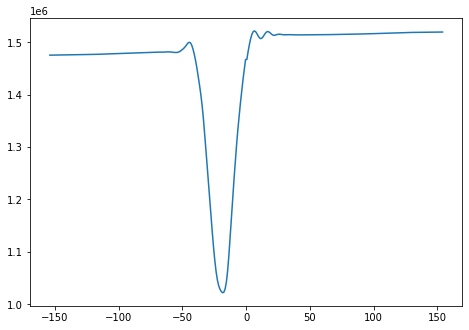

In [6]:
err_y = np.append(np.flip(err_y_down), err_y_up)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(np.linspace(-shift_y, shift_y, num=shift_y*2), err_y)
fig.savefig("error_y.jpg", bbox_inches="tight")

In [7]:
shift_x = math.trunc(img.shape[2]/20)

err_x_left = np.empty((shift_x), dtype=np.float64)
err_x_right = np.empty((shift_x), dtype=np.float64)

top = img[0]
bot = img[-1]

# x-axis shift-right
for i in range(0, shift_x):
    # subtract pixel values from first and last slices
    sub = top - bot
    err_x_right[i] = np.sqrt(np.sum(np.square(sub)))

    top = np.delete(top, -1, axis=1)
    bot = np.delete(bot, 0, axis=1)

top = img[0]
bot = img[-1]

# x-axis shift-left
for i in range(0, shift_x):
    # subtract pixel values from first and last slices
    sub = top - bot
    err_x_left[i] = np.sqrt(np.sum(np.square(sub)))

    top = np.delete(top, 0, axis=1)
    bot = np.delete(bot, -1, axis=1)

In [8]:
vertex_right = np.amin(err_x_right)
vertex_left = np.amin(err_x_left)

if vertex_right < vertex_left:
    err_factor_x = np.where(err_x_right == vertex_right)[0][0]
    correction_x = np.delete(img[0], slice(-1-err_factor_x, -1), axis=1) - np.delete(img[1], slice(0, err_factor_x), axis=1)
    print(f"Shift right by {err_factor_x} columns")
else:
    err_factor_x = np.where(err_x_left == vertex_left)[0][0]
    correction_x = np.delete(img[0], slice(0, err_factor_x), axis=1) - np.delete(img[1], slice(-1-err_factor_x, -1), axis=1)
    print(f"Shift right by {err_factor_x} columns")

Shift right by 3 columns


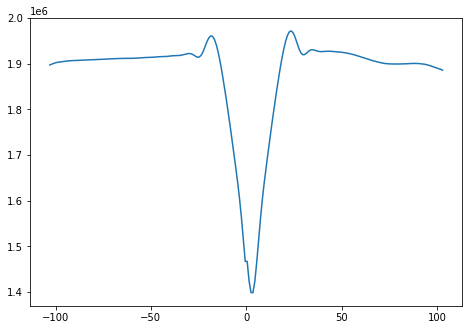

In [9]:
err_x = np.append(np.flip(err_x_left), err_x_right)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(np.linspace(-shift_x, shift_x, num=shift_x*2), err_x)
fig.savefig("error_x.jpg", bbox_inches="tight")

In [10]:
viewer.dims.axis_labels = ("z", "y", "x")

viewer.add_image(img)
viewer.add_image(subtraction)
viewer.add_image(correction_y)
viewer.add_image(correction_x)

<Image layer 'correction_x' at 0x13b2bfd4100>